In [36]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.utils import resample
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import seaborn as sns
from sklearn.metrics import confusion_matrix





Unificazione di tutti i file .csv in un'unica variabile data

In [2]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "MachineLearningCSV" / "MachineLearningCVE"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    #df["source_file"] = file.name   # tracciabilità (facoltativa ma utile)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()
#data.shape
#data.columns

Numero di file CSV trovati: 8
Caricamento file 1/8 → Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Caricamento file 2/8 → Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Caricamento file 3/8 → Friday-WorkingHours-Morning.pcap_ISCX.csv
Caricamento file 4/8 → Monday-WorkingHours.pcap_ISCX.csv
Caricamento file 5/8 → Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Caricamento file 6/8 → Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Caricamento file 7/8 → Tuesday-WorkingHours.pcap_ISCX.csv
Caricamento file 8/8 → Wednesday-workingHours.pcap_ISCX.csv


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Operazioni di pulizia del dataset come ad esempio, rimozione di spazi accidentali nei nomi delle colonne ed eliminazione delle righe con almeno un valore NaN

In [11]:
# 1) Normalizzazione nomi colonne
data.columns = data.columns.str.strip()

# 2) Pulizia sintattica Label (tenuta solo per valutazione ex post)
if "Label" in data.columns:
    data["Label"] = data["Label"].astype(str).str.strip()

# 3) Rimozione colonne identificative / temporali non utili
cols_to_drop = [
    "Flow ID",
    "Timestamp",
    "Src IP",
    "Dst IP",
    "Source IP",
    "Destination IP",
    "Src Port",
    "Dst Port",
    "Source Port",
    "Destination Port"
]
data.drop(columns=[c for c in cols_to_drop if c in data.columns], inplace=True)

# 4) Conversione numerica SOLO delle feature (Label resta stringa)
feature_cols = [c for c in data.columns if c != "Label"]
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors="coerce")

# 5) Sostituzione inf con NaN 
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.info()

# colonne con più NaN
data[feature_cols].isna().sum(axis=0).sort_values(ascending=False).head(20)

# 6) Drop righe con NaN sulle sole feature (Label rimane allineata automaticamente)
data = data.dropna(subset=feature_cols).copy()

# 7) Separazione features e label (ora allineate per costruzione)
if "Label" in data.columns:
    y_label = data["Label"].reset_index(drop=True)
    X = data.drop(columns=["Label"]).reset_index(drop=True)
else:
    y_label = None
    X = data.reset_index(drop=True)

# (controllo allineamento)
if y_label is not None:
    print("Righe X:", X.shape[0], "Righe y_label:", len(y_label))
    assert X.shape[0] == len(y_label)

# 8) Rimozione feature costanti (varianza zero) PRIMA dello scaling
n_unique = X.nunique()
constant_cols = n_unique[n_unique == 1].index
print(f"Colonne costanti rimosse (varianza zero): {len(constant_cols)}")
X = X.drop(columns=constant_cols)

# 9) Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

print("Shape finale feature matrix (scaled):", X_scaled.shape)
X_scaled.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  int64  
 4   Total Length of Bwd Packets  int64  
 5   Fwd Packet Length Max        int64  
 6   Fwd Packet Length Min        int64  
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        int64  
 10  Bwd Packet Length Min        int64  
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 int64  
 18  Flow IAT Min                 int64  
 19  

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.439612,-0.009825,-0.010426,-0.053793,-0.007145,-0.281253,-0.210906,-0.280686,-0.245193,-0.447694,...,-0.006947,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
1,-0.439609,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2,-0.439611,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
3,-0.439612,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
4,-0.439612,-0.009825,-0.010426,-0.053793,-0.007145,-0.281253,-0.210906,-0.280686,-0.245193,-0.447694,...,-0.006947,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184


ELBOW METHOD

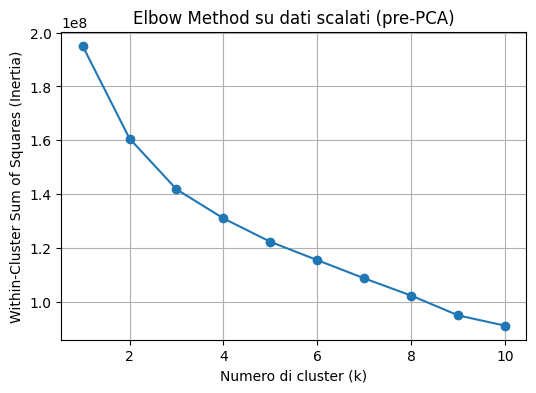

In [12]:
# Elbow Method per KMeans su dati scalati (pre-PCA)
distortions = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10      # stabilità della soluzione
    )
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, distortions, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method su dati scalati (pre-PCA)')
plt.grid(True)
plt.show()


KMEANS

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)

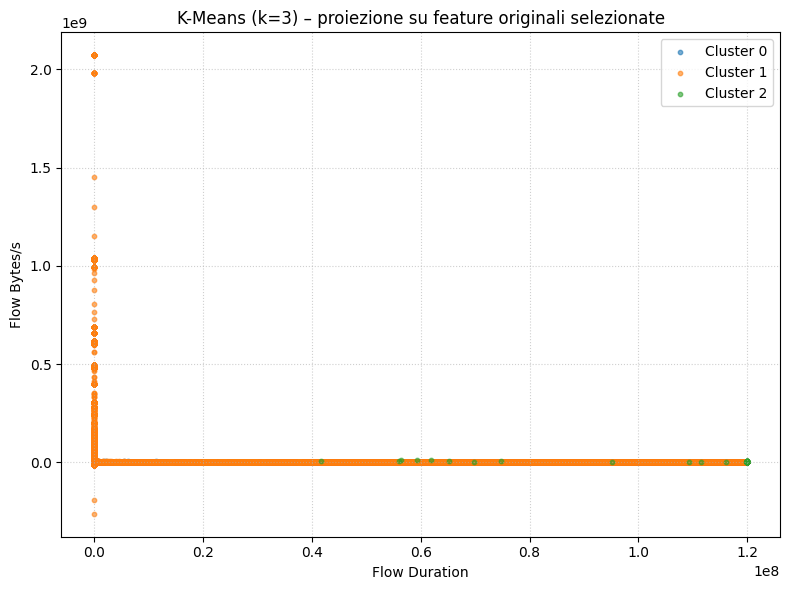

In [14]:
plt.figure(figsize=(8, 6))
for c in np.unique(labels_kmeans):
    plt.scatter(
        X.loc[labels_kmeans == c, "Flow Duration"],
        X.loc[labels_kmeans == c, "Flow Bytes/s"],
        s=10,
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Flow Duration")
plt.ylabel("Flow Bytes/s")
plt.title("K-Means (k=3) – proiezione su feature originali selezionate")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


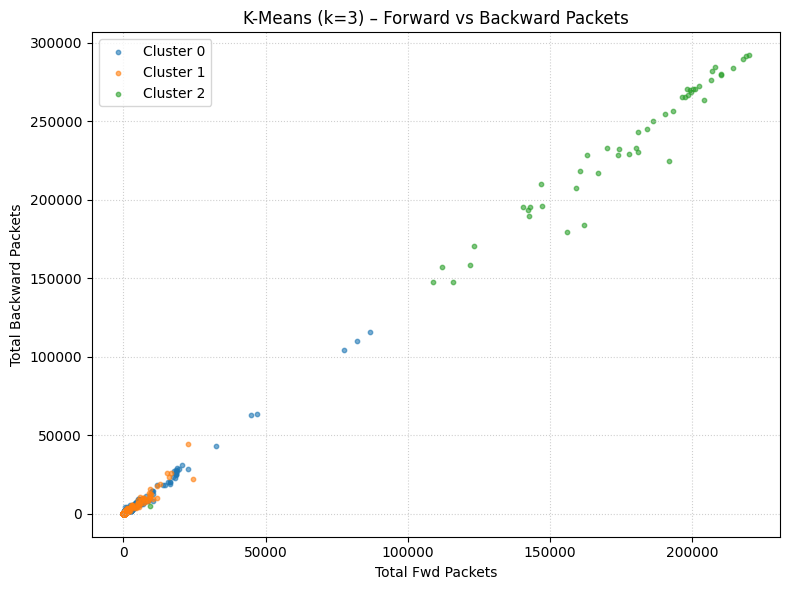

In [15]:
plt.figure(figsize=(8, 6))
for c in np.unique(labels_kmeans):
    plt.scatter(
        X.loc[labels_kmeans == c, "Total Fwd Packets"],
        X.loc[labels_kmeans == c, "Total Backward Packets"],
        s=10,
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Total Fwd Packets")
plt.ylabel("Total Backward Packets")
plt.title("K-Means (k=3) – Forward vs Backward Packets")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


Silhouette Score medio (KMeans, spazio originale): 0.587


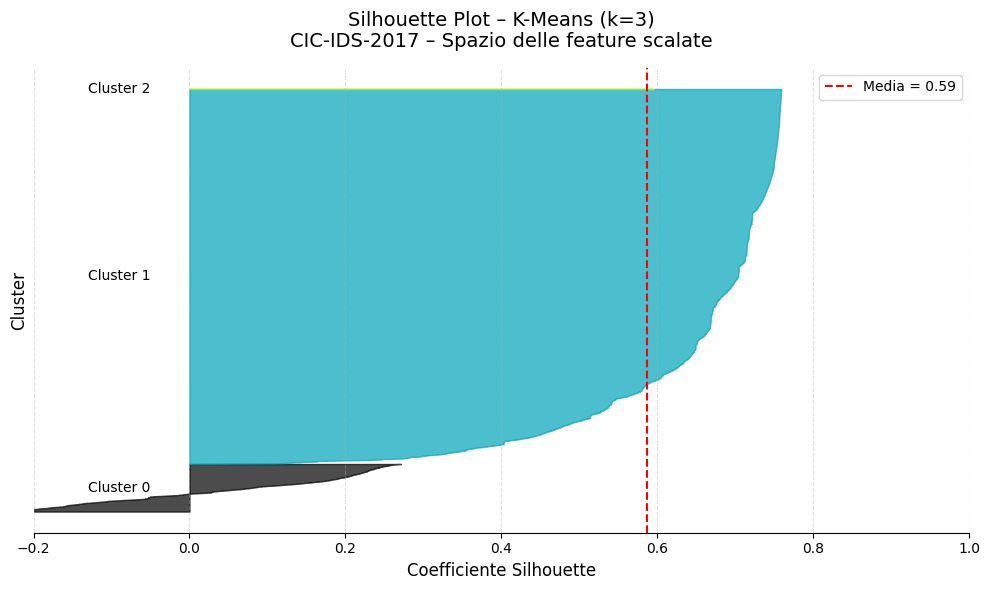

In [16]:
# Valutazione KMeans con silhouette score su dati scalati (pre-PCA)

# Campionamento
sample_size = min(100000, X_scaled.shape[0])

X_sampled, labels_sampled = resample(
    X_scaled,
    labels_kmeans,
    n_samples=sample_size,
    random_state=42
)

n_clusters = len(np.unique(labels_sampled))


# Calcolo silhouette
silhouette_avg = silhouette_score(X_sampled, labels_sampled)
silhouette_vals = silhouette_samples(X_sampled, labels_sampled)

print(f"Silhouette Score medio (KMeans, spazio originale): {silhouette_avg:.3f}")

# Silhouette Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

cmap = cm.nipy_spectral

for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[labels_sampled == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cmap(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    ax.text(
        -0.05,
        y_lower + 0.5 * size_cluster_i,
        f"Cluster {i}",
        va="center",
        ha="right",
        fontsize=10
    )

    y_lower = y_upper + 10

# Linea della silhouette media
ax.axvline(
    x=silhouette_avg,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Media = {silhouette_avg:.2f}"
)

# Formattazione grafico
ax.set_title(
    "Silhouette Plot – K-Means (k=3)\nCIC-IDS-2017 – Spazio delle feature scalate",
    fontsize=14,
    pad=15
)
ax.set_xlabel("Coefficiente Silhouette", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)

ax.set_xlim([-0.2, 1.0])
ax.set_yticks([])
ax.grid(axis="x", linestyle="--", alpha=0.4)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()



Clustering gerarchico

In [17]:
# Campionamento 
sample_size = min(20000, X_scaled.shape[0])

idx = np.random.RandomState(42).choice(
    X_scaled.shape[0],
    size=sample_size,
    replace=False
)

X_sample = X_scaled.iloc[idx]
X_sample_orig = X.iloc[idx]

# Clustering gerarchico (Ward)
hc = AgglomerativeClustering(
    n_clusters=3,
    metric="euclidean",   # con 'ward' deve essere euclidea
    linkage="ward"
)

labels_hc = hc.fit_predict(X_sample)

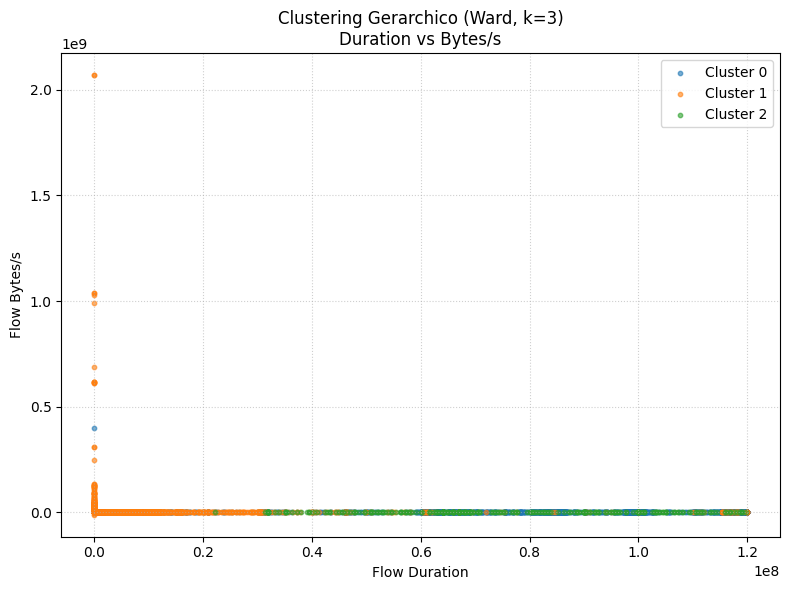

In [18]:
plt.figure(figsize=(8, 6))

for c in np.unique(labels_hc):
    plt.scatter(
        X_sample_orig.loc[labels_hc == c, "Flow Duration"],
        X_sample_orig.loc[labels_hc == c, "Flow Bytes/s"],
        s=10,
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Flow Duration")
plt.ylabel("Flow Bytes/s")
plt.title("Clustering Gerarchico (Ward, k=3)\nDuration vs Bytes/s")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


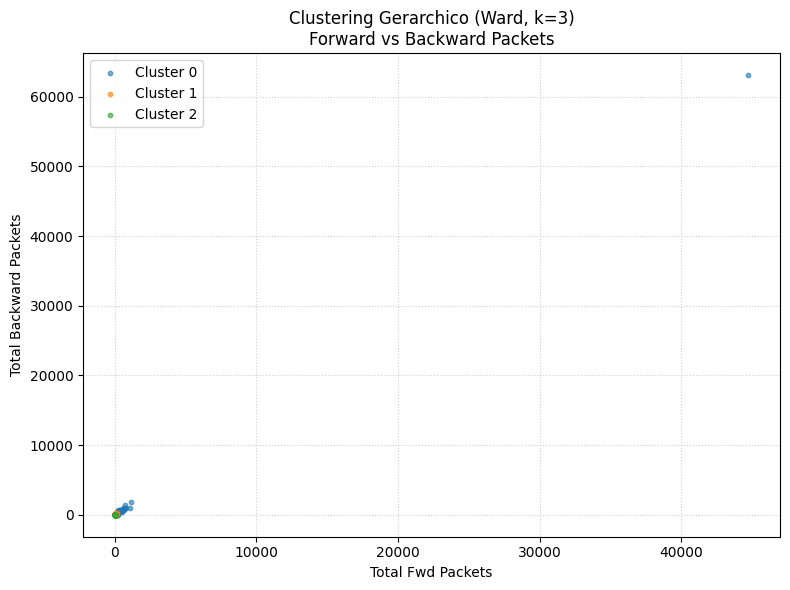

In [19]:
plt.figure(figsize=(8, 6))

for c in np.unique(labels_hc):
    plt.scatter(
        X_sample_orig.loc[labels_hc == c, "Total Fwd Packets"],
        X_sample_orig.loc[labels_hc == c, "Total Backward Packets"],
        s=10,
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Total Fwd Packets")
plt.ylabel("Total Backward Packets")
plt.title("Clustering Gerarchico (Ward, k=3)\nForward vs Backward Packets")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


Silhouette Score medio (Gerarchico/Ward, campione): 0.501


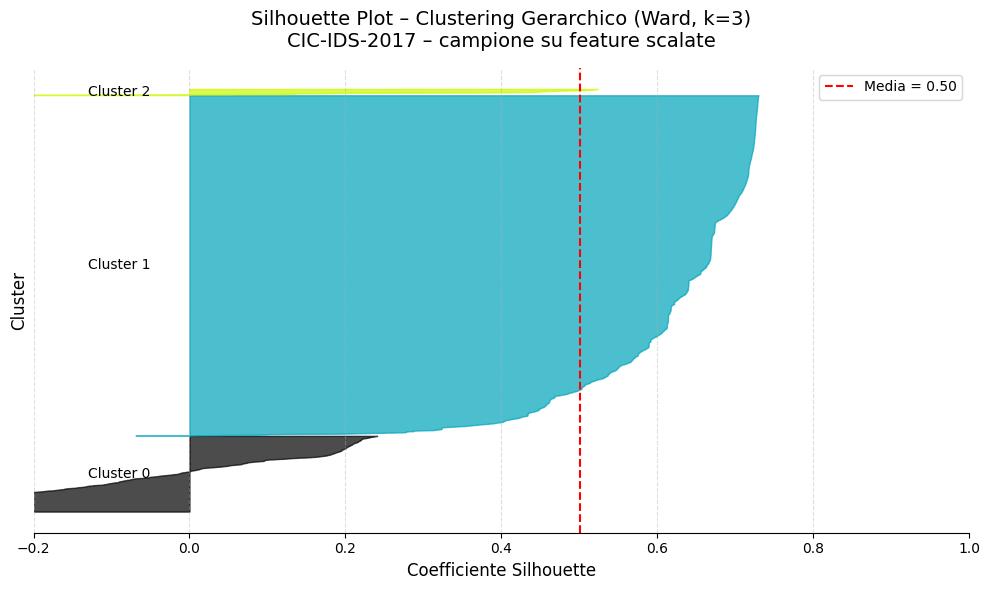

In [20]:
# Silhouette 
if len(np.unique(labels_hc)) > 1:
    sil_avg = silhouette_score(X_sample, labels_hc)
    sil_vals = silhouette_samples(X_sample, labels_hc)
    print(f"Silhouette Score medio (Gerarchico/Ward, campione): {sil_avg:.3f}")

    # ===== Silhouette Plot =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower = 10
    n_clusters = len(np.unique(labels_hc))
    cmap = cm.nipy_spectral

    for i in range(n_clusters):
        vals = sil_vals[labels_hc == i]
        vals.sort()
        size_i = vals.shape[0]
        y_upper = y_lower + size_i

        color = cmap(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_i, f"Cluster {i}",
                va="center", ha="right", fontsize=10)

        y_lower = y_upper + 10

    ax.axvline(sil_avg, color="red", linestyle="--", linewidth=1.5,
               label=f"Media = {sil_avg:.2f}")

    ax.set_title("Silhouette Plot – Clustering Gerarchico (Ward, k=3)\nCIC-IDS-2017 – campione su feature scalate",
                 fontsize=14, pad=15)
    ax.set_xlabel("Coefficiente Silhouette", fontsize=12)
    ax.set_ylabel("Cluster", fontsize=12)
    ax.set_xlim([-0.2, 1.0])
    ax.set_yticks([])
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

else:
    print("Silhouette non calcolabile: identificato un solo cluster nel campione.")

PCA

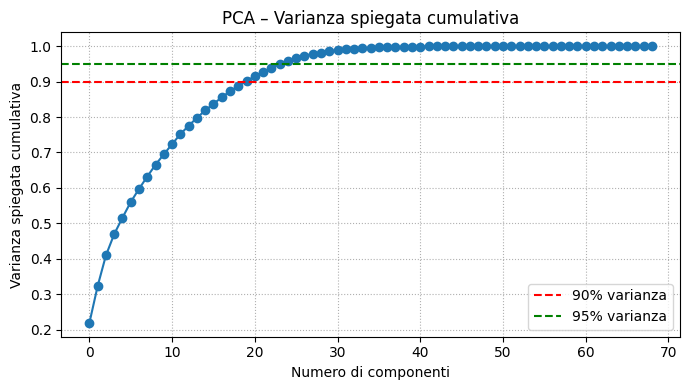

In [21]:
# PCA senza fissare il numero di componenti
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

# Varianza spiegata cumulativa
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(7, 4))
plt.plot(explained_variance, marker='o')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% varianza')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% varianza')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('PCA – Varianza spiegata cumulativa')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


In [22]:
# PCA con soglia di varianza spiegata al 90%
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Numero di componenti PCA selezionate: {X_pca.shape[1]}")


Numero di componenti PCA selezionate: 20


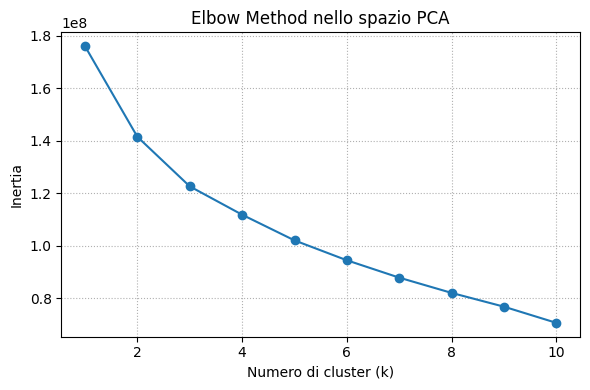

In [23]:
# Elbow Method per KMeans su dati PCA
distortions_pca = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    distortions_pca.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, distortions_pca, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method nello spazio PCA')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


Kmeans su PCA

In [24]:
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)


Silhouette Score medio (KMeans, spazio originale): 0.616


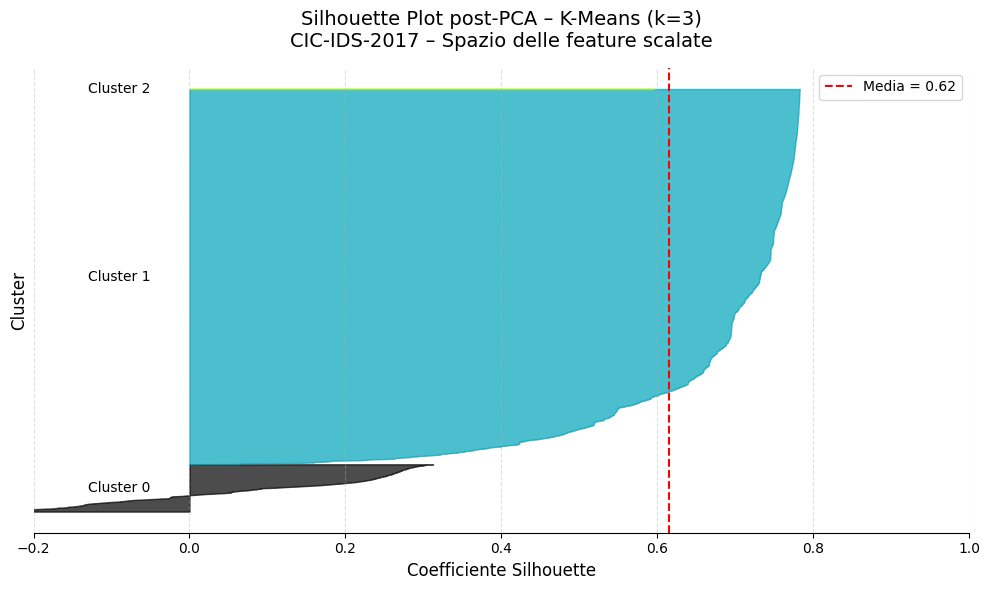

In [25]:
# Valutazione KMeans con silhouette score su dati scalati (post-PCA)

# Campionamento
sample_size = min(100000, X_scaled.shape[0])

X_sampled, labels_sampled = resample(
    X_pca,
    labels_pca,
    n_samples=sample_size,
    random_state=42
)

n_clusters = len(np.unique(labels_sampled))


# Calcolo silhouette 
silhouette_avg = silhouette_score(X_sampled, labels_sampled)
silhouette_vals = silhouette_samples(X_sampled, labels_sampled)

print(f"Silhouette Score medio (KMeans, spazio originale): {silhouette_avg:.3f}")

# Silhouette Plot post-PCA
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

cmap = cm.nipy_spectral

for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[labels_sampled == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cmap(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    ax.text(
        -0.05,
        y_lower + 0.5 * size_cluster_i,
        f"Cluster {i}",
        va="center",
        ha="right",
        fontsize=10
    )

    y_lower = y_upper + 10

# Linea della silhouette media
ax.axvline(
    x=silhouette_avg,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Media = {silhouette_avg:.2f}"
)

# Formattazione grafico
ax.set_title(
    "Silhouette Plot post-PCA – K-Means (k=3)\nCIC-IDS-2017 – Spazio delle feature scalate",
    fontsize=14,
    pad=15
)
ax.set_xlabel("Coefficiente Silhouette", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)

ax.set_xlim([-0.2, 1.0])
ax.set_yticks([])
ax.grid(axis="x", linestyle="--", alpha=0.4)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


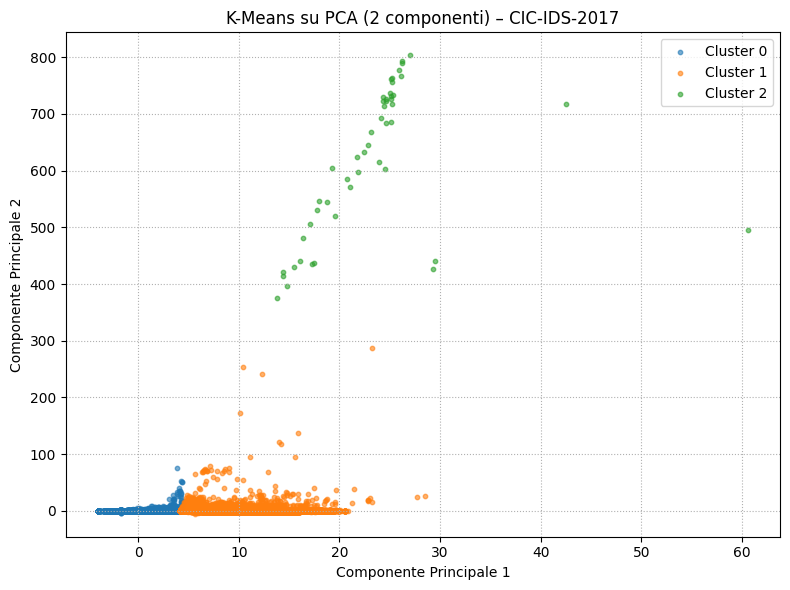

In [26]:
# Visualizzazione KMeans su prime 2 componenti PCA
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

kmeans_2d = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_2d = kmeans_2d.fit_predict(X_pca_2d)

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(
        X_pca_2d[labels_2d == i, 0],
        X_pca_2d[labels_2d == i, 1],
        s=10,
        alpha=0.6,
        label=f"Cluster {i}"
    )

plt.title("K-Means su PCA (2 componenti) – CIC-IDS-2017")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


DBSCAN

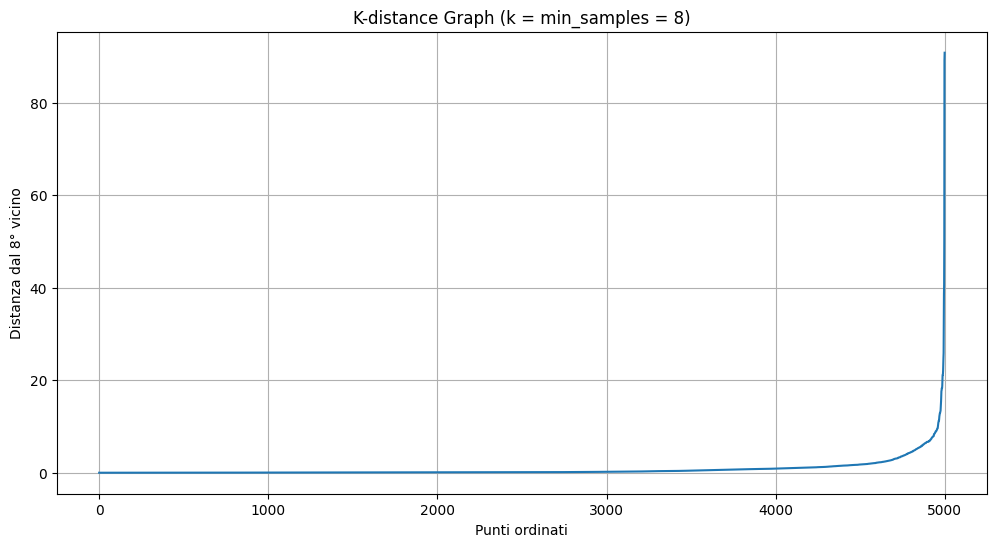

In [27]:
#campione per stimare eps 
X_db = resample(X_pca, n_samples=min(5000, X_pca.shape[0]), random_state=42)

min_samples = 8  
nn = NearestNeighbors(n_neighbors=min_samples, metric="euclidean")
nn.fit(X_db)

distances, _ = nn.kneighbors(X_db)
k_dist = np.sort(distances[:, -1])  # distanza dal k-esimo vicino

plt.figure(figsize=(12, 6))
plt.plot(k_dist)
plt.title(f"K-distance Graph (k = min_samples = {min_samples})")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza dal {min_samples}° vicino")
plt.grid(True)
plt.show()


In [28]:
# DBSCAN con parametri scelti

eps = 2.5
min_samples = 8

# campione per DBSCAN 
X_db = resample(X_pca, n_samples=min(50000, X_pca.shape[0]), random_state=42)

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", n_jobs=-1)
db_labels = dbscan.fit_predict(X_db)

unique, counts = np.unique(db_labels, return_counts=True)
label_counts = dict(zip(unique, counts))

n_clusters = len(label_counts) - (1 if -1 in label_counts else 0)
noise_pct = 100 * label_counts.get(-1, 0) / len(db_labels)

print("Distribuzione etichette:", label_counts)
print(f"Numero cluster (escluso rumore): {n_clusters}")
print(f"Percentuale rumore: {noise_pct:.2f}%")



Distribuzione etichette: {-1: 732, 0: 42887, 1: 1750, 2: 720, 3: 60, 4: 798, 5: 15, 6: 264, 7: 1904, 8: 10, 9: 49, 10: 68, 11: 12, 12: 15, 13: 65, 14: 18, 15: 42, 16: 66, 17: 107, 18: 52, 19: 8, 20: 35, 21: 9, 22: 15, 23: 8, 24: 21, 25: 12, 26: 44, 27: 31, 28: 11, 29: 15, 30: 30, 31: 13, 32: 16, 33: 13, 34: 16, 35: 22, 36: 9, 37: 8, 38: 11, 39: 11, 40: 8}
Numero cluster (escluso rumore): 41
Percentuale rumore: 1.46%


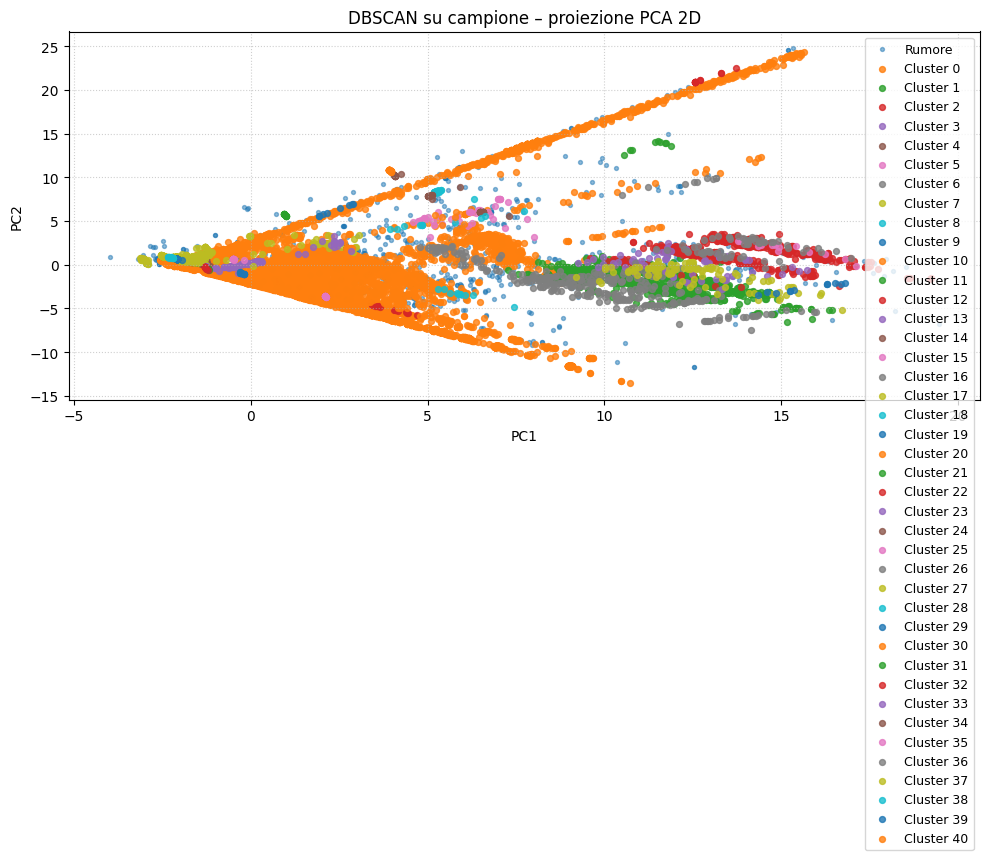

In [29]:
# crea anche la proiezione 2D del campione DBSCAN
pca_2d = PCA(n_components=2, random_state=42)
X_db_2d = pca_2d.fit_transform(X_db)

plt.figure(figsize=(10, 7))
for lab in np.unique(db_labels):
    if lab == -1:
        name, s, a = "Rumore", 8, 0.5
    else:
        name, s, a = f"Cluster {lab}", 18, 0.8

    plt.scatter(X_db_2d[db_labels == lab, 0], X_db_2d[db_labels == lab, 1],
                s=s, alpha=a, label=name)

plt.title("DBSCAN su campione – proiezione PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(fontsize=9, framealpha=0.8)
plt.tight_layout()
plt.show()


In [30]:
# DBSCAN con eps=2.8 per confroto

eps = 2.8
min_samples = 8

# campione per DBSCAN 
X_db = resample(X_pca, n_samples=min(50000, X_pca.shape[0]), random_state=42)

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", n_jobs=-1)
db_labels = dbscan.fit_predict(X_db)

unique, counts = np.unique(db_labels, return_counts=True)
label_counts = dict(zip(unique, counts))

n_clusters = len(label_counts) - (1 if -1 in label_counts else 0)
noise_pct = 100 * label_counts.get(-1, 0) / len(db_labels)

print("Distribuzione etichette:", label_counts)
print(f"Numero cluster (escluso rumore): {n_clusters}")
print(f"Percentuale rumore: {noise_pct:.2f}%")

Distribuzione etichette: {-1: 599, 0: 43032, 1: 1753, 2: 720, 3: 60, 4: 849, 5: 15, 6: 264, 7: 1969, 8: 10, 9: 68, 10: 12, 11: 15, 12: 68, 13: 22, 14: 47, 15: 70, 16: 109, 17: 53, 18: 35, 19: 9, 20: 17, 21: 8, 22: 21, 23: 12, 24: 31, 25: 11, 26: 11, 27: 15, 28: 13, 29: 16, 30: 16, 31: 13, 32: 8, 33: 8, 34: 10, 35: 11}
Numero cluster (escluso rumore): 36
Percentuale rumore: 1.20%


In [31]:
# DBSCAN con eps=2.2 per confronto

eps = 2.2
min_samples = 8

# campione per DBSCAN 
X_db = resample(X_pca, n_samples=min(50000, X_pca.shape[0]), random_state=42)

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", n_jobs=-1)
db_labels = dbscan.fit_predict(X_db)

unique, counts = np.unique(db_labels, return_counts=True)
label_counts = dict(zip(unique, counts))

n_clusters = len(label_counts) - (1 if -1 in label_counts else 0)
noise_pct = 100 * label_counts.get(-1, 0) / len(db_labels)

print("Distribuzione etichette:", label_counts)
print(f"Numero cluster (escluso rumore): {n_clusters}")
print(f"Percentuale rumore: {noise_pct:.2f}%")

Distribuzione etichette: {-1: 969, 0: 41883, 1: 1747, 2: 719, 3: 60, 4: 796, 5: 15, 6: 240, 7: 1782, 8: 10, 9: 301, 10: 48, 11: 8, 12: 449, 13: 67, 14: 85, 15: 12, 16: 15, 17: 63, 18: 18, 19: 39, 20: 57, 21: 106, 22: 52, 23: 39, 24: 8, 25: 24, 26: 35, 27: 9, 28: 11, 29: 15, 30: 21, 31: 12, 32: 23, 33: 19, 34: 31, 35: 11, 36: 15, 37: 29, 38: 13, 39: 16, 40: 39, 41: 13, 42: 15, 43: 22, 44: 8, 45: 23, 46: 8}
Numero cluster (escluso rumore): 47
Percentuale rumore: 1.94%


CONFRONTO FINALE

In [33]:
# Campionamento etichette DBSCAN per confronto con label originali
_, y_label_db = resample(
    X_pca,
    y_label,
    n_samples=len(db_labels),
    random_state=42
)

In [34]:
# crea DataFrame con label DBSCAN e label reale
df_eval = pd.DataFrame({
    "dbscan": db_labels,
    "label_true": y_label_db
})

purity_per_cluster = {}
total_points = len(df_eval)

for cluster in np.unique(db_labels):
    if cluster == -1:
        continue  # salto rumore o lo tratterò a parte
    sub = df_eval[df_eval["dbscan"] == cluster]
    most_freq = sub["label_true"].value_counts().idxmax()
    freq = sub["label_true"].value_counts().max()
    purity_per_cluster[cluster] = freq / len(sub)

# purity complessiva
weighted_purity = sum(
    len(df_eval[df_eval["dbscan"] == c]) * purity_per_cluster[c]
    for c in purity_per_cluster
) / total_points

print("Purity per cluster:", purity_per_cluster)
print(f"Purity complessiva: {weighted_purity:.3f}")


Purity per cluster: {0: 0.8521357113864814, 1: 0.9072696050372067, 2: 1.0, 3: 1.0, 4: 0.8266331658291457, 5: 1.0, 6: 0.8833333333333333, 7: 0.9590347923681257, 8: 1.0, 9: 0.53156146179402, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.7611940298507462, 14: 0.9647058823529412, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 0.8333333333333334, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 0.9523809523809523, 31: 1.0, 32: 1.0, 33: 1.0, 34: 0.6774193548387096, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 0.875, 45: 1.0, 46: 1.0}
Purity complessiva: 0.845


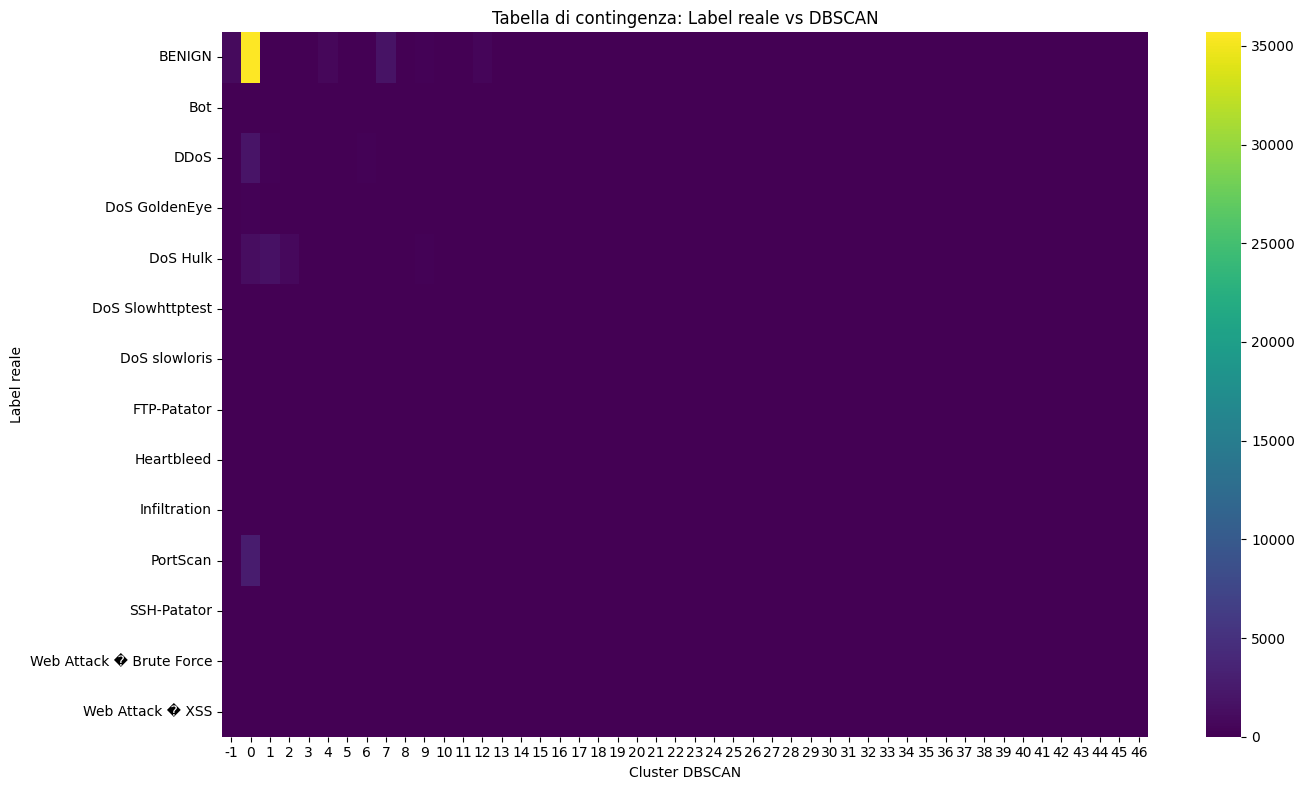

In [38]:
# tabella label vera (righe) vs cluster DBSCAN (colonne)
ct = pd.crosstab(df_eval["label_true"], df_eval["dbscan"])

plt.figure(figsize=(14, 8))
sns.heatmap(ct, cmap="viridis")  # annot=False di default
plt.title("Tabella di contingenza: Label reale vs DBSCAN")
plt.xlabel("Cluster DBSCAN")
plt.ylabel("Label reale")
plt.tight_layout()
plt.show()



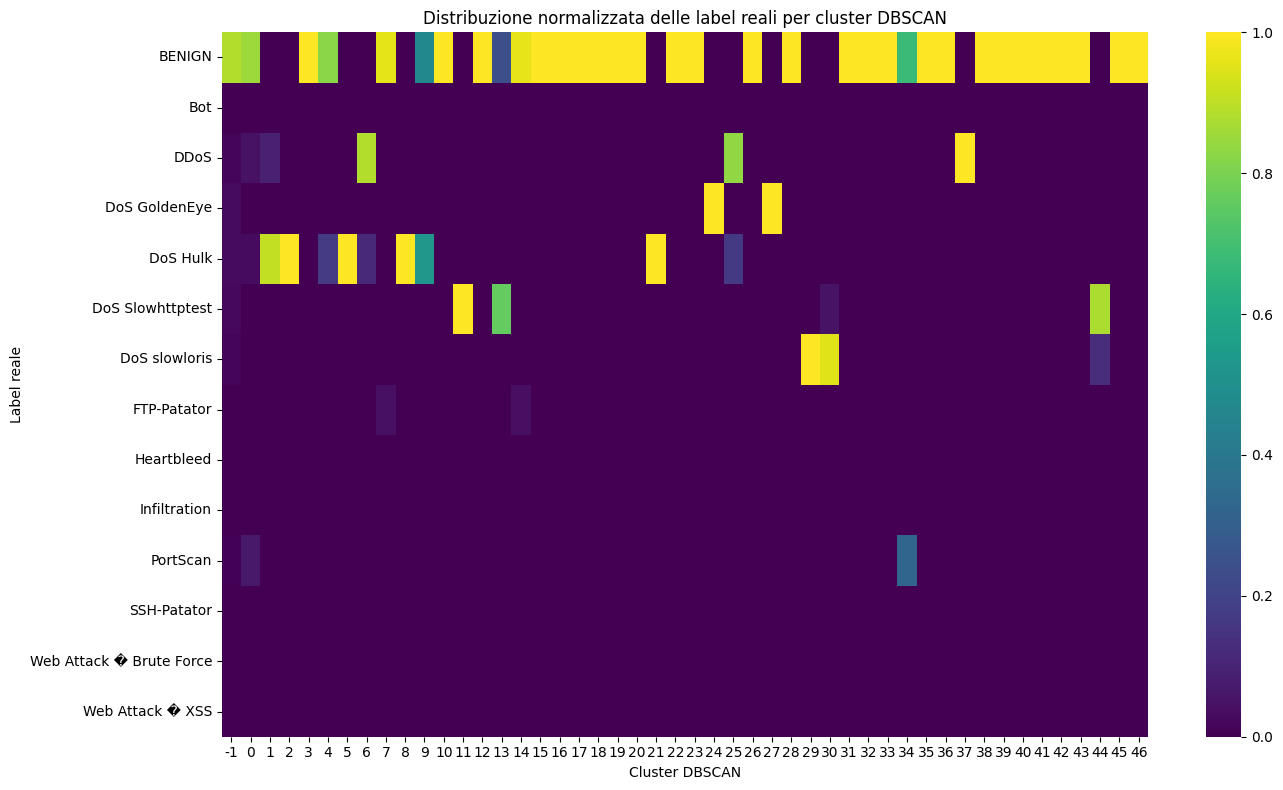

In [39]:
ct = pd.crosstab(df_eval["label_true"], df_eval["dbscan"])
ct_norm = ct.div(ct.sum(axis=0), axis=1)  # normalizza per cluster

plt.figure(figsize=(14, 8))
sns.heatmap(ct_norm, cmap="viridis")
plt.title("Distribuzione normalizzata delle label reali per cluster DBSCAN")
plt.xlabel("Cluster DBSCAN")
plt.ylabel("Label reale")
plt.tight_layout()
plt.show()


In [40]:
# purezza di ogni cluster
cluster_purity = ct_norm.max(axis=0)

cluster_purity.sort_values(ascending=False).head(10)


dbscan
23    1.0
35    1.0
24    1.0
26    1.0
27    1.0
28    1.0
29    1.0
31    1.0
32    1.0
33    1.0
dtype: float64